## Building FootPrint Detection

In [1]:
import numpy as np
import cv2
import os 
from  glob import glob 
from matplotlib import pyplot as plt 

data_path = "/home/azureuser/cloudfiles/code/Users/samarth.tandon/BFP-detector/data"
train_path = os.path.join(data_path,'train')
test_path = os.path.join(data_path,'test')

train_images = glob(train_path+'/*.png')
test_images = glob(test_path+'/*.png')

print("Training images: ",len(train_images))
print("Testing images: ",len(test_images))
print("IMG_shape: 1500x1500x3\n")


Training images:  141
Testing images:  10
IMG_shape: 1500x1500x3



In [2]:
IMG_SHAPE = (512,512,3)
def remove_unwanted_files(train_input_dir,train_output_dir):
    ## Remove the images whose corresponding output mask image is not present 
    not_imgs = []
    for imgs in os.listdir(train_input_dir):
        out_img = os.path.join(train_output_dir,imgs)
        if not os.path.isfile(out_img):
            not_img = os.path.join(train_input_dir,imgs)
            os.remove(not_img)
        else:
            continue

def display_predictions(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(8,7))
    axs[2].imshow(mask[:,:,0],cmap="gray")
    axs[2].set_title('Predicted')
    axs[1].imshow(groud_truth[:,:,0], cmap="gray")
    axs[1].set_title('GroundTruth')
    axs[0].imshow(img)
    axs[0].set_title('Map Input Image')
    plt.show()
    return 0
    
def plot_training_history(history):
    
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
    return 0

def get_sample_image(target_shape=IMG_SHAPE):
    image_name = test_images[np.random.randint(0,len(test_images))]
    mask_name = image_name.replace('test','test_labels')
    
    input_image = cv2.imread(image_name)
    input_image = cv2.cvtColor(cv2.resize(input_image,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA),cv2.COLOR_BGR2RGB)

    mask_img = cv2.imread(mask_name)
    mask_img = cv2.resize(mask_img,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA)
    
    input_image = input_image/255.0
    mask_img = mask_img/255.0
    return input_image,mask_img

def decode_segmentation_masks(mask, n_classes=2):
    gray = np.zeros_like(mask).astype(np.uint8)
    
    idx = mask >0.5 # since sigmoid function is used in binary model 
    gray[idx] = 255
    return gray

## Mask to BBOX

In [3]:
from skimage.measure import label, regionprops, find_contours

""" Convert a mask to border image """
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border

""" Mask to bounding boxes """
def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes

def map_bboxes(boxes , image):
    x = image.copy()
    for bbox in boxes:
        x = cv2.rectangle(x, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    return x
    

## Visualize the data

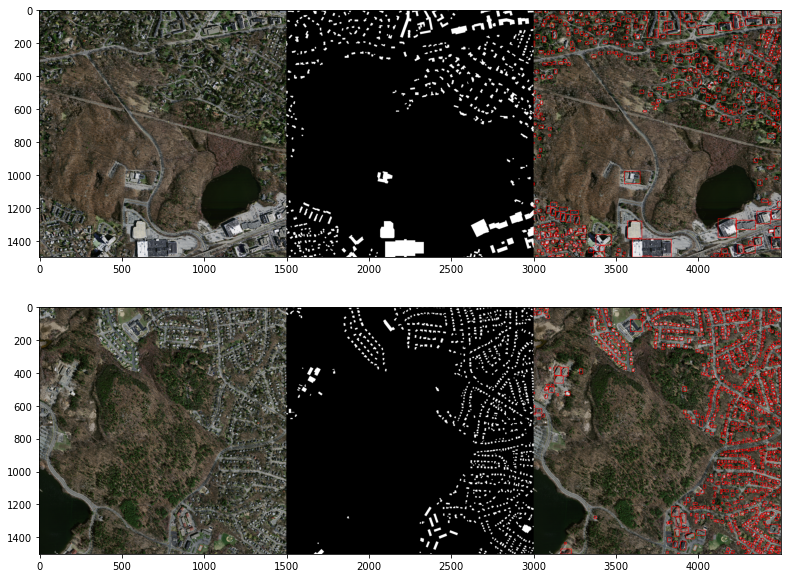

In [4]:
image_ids = np.random.choice(train_images, 2)

plt.figure(figsize=(20,10))
count = 0 
for image_id in image_ids:
    input_img = cv2.imread(image_id)
    input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    mask_img= cv2.imread(image_id.replace('train','train_labels'))
    mask_img_gray = cv2.cvtColor(mask_img,cv2.COLOR_RGB2GRAY)
    bbox = mask_to_bbox(mask_img_gray)
    mapped_image = map_bboxes(bbox,input_img)
    concat_img = cv2.hconcat([input_img,mask_img,mapped_image])
    count +=1
    if count>2:break 
    plt.subplot(2,1,count)
    plt.imshow(concat_img)

## Data Augmentation

In [5]:
# Add Augmentation 
import albumentations as A

def albu_transform_train():
    return A.Compose([A.RandomRotate90(p=0.1),
                      A.Transpose(p=0.5),
                      A.Blur(p=0.01, blur_limit = 3),
                      A.RandomBrightnessContrast(p=0.1),
                      A.OneOf([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)],p=0.5)
                      ],p=1)

def albu_transform_valid():
    return A.Compose([A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.1)])

## Data Generator

In [6]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size=1, image_size=512, shuffle=True, transform=None):
        """Initialization
        :param image_files: list of all images ids (file names)
        :param mask_files: list of mask labels (file names)
        :param batch_size: create batch of images
        :param image_size: path to masks location
        :param shuffle: True to shuffle label indexes after every epoch
        :param augment: To set augmentation Flag True/False
        """
        self.image_filenames = image_files
        self.mask_names = mask_files
        self.batch_size = batch_size
        self.image_shape = (image_size, image_size)
        self.list_IDs = np.arange(len(self.image_filenames))
        self.shuffle = shuffle
        self.augmentation = transform
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle: 
            np.random.shuffle(self.indexes)

    def read_image_mask(self, image_name, mask_name):
        input_img = cv2.imread(image_name)
        input_img = cv2.resize(input_img,self.image_shape,cv2.INTER_AREA)
        input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
        input_img = input_img.astype(np.float32)

        mask_img = cv2.imread(mask_name)
        mask_img = cv2.cvtColor(cv2.resize(mask_img,self.image_shape,cv2.INTER_AREA) ,cv2.COLOR_BGR2GRAY)
        mask_img = np.reshape(mask_img,(mask_img.shape[0],mask_img.shape[1],1))
        mask_img = mask_img.astype(np.float32)
        return input_img/255.0, mask_img/255.0
    
    def transform_data(self,image,mask):
        transformed = self.augmentation(image=image, mask=mask)
        transform_image = transformed['image']
        transform_mask = transformed['mask']
        return transform_image,transform_mask

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Defining dataset
        X = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], 3),dtype=np.float32)
        Y = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], 1),dtype=np.float32)
        
        for i, index in enumerate(list_IDs_temp):
            X_sample, Y_sample = self.read_image_mask(self.image_filenames[index],self.mask_names[index])
            # X_sample, Y_sample = self.read_image_mask(self.image_filenames[index],self.mask_names[index])
            if self.augmentation is not None:
                X_sample, Y_sample = self.transform_data(X_sample,Y_sample)
            if self.batch_size == 1:
                X = np.reshape(X_sample,(1,X_sample.shape[0], X_sample.shape[1],3))
                Y = np.reshape(Y_sample,(1,Y_sample.shape[0], Y_sample.shape[1],1))
                return X,Y
            else:        
                X[i, ...] = X_sample
                Y[i, ...] = Y_sample
        return X, Y

In [7]:
mask_train_images = [img_name.replace('train','train_labels') for img_name in train_images]
mask_test_images = [img_name.replace('test','test_labels') for img_name in test_images]

print("mask Train Images ",len(mask_train_images))
print("mask test images ",len(mask_test_images))

mask Train Images  141
mask test images  10


In [8]:
# setting generators
train_generator = DataGenerator(image_files= train_images, mask_files = mask_train_images, batch_size=1,transform=albu_transform_train())

test_generator = DataGenerator(image_files= test_images,mask_files=mask_test_images,batch_size=1)


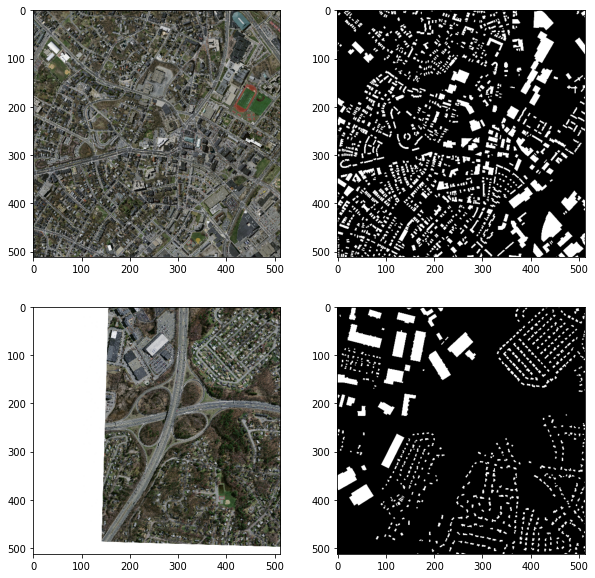

In [9]:
plt.figure(figsize=(10,10))
count = 0
for i in range(4):
    Xtest, ytest = train_generator.__getitem__(i)
    output_img = ytest[0, :,:,0]
    
    if count>=4:break 
    count +=1
    plt.subplot(2,2,count)
    plt.imshow(Xtest[0])
    count +=1
    plt.subplot(2,2,count)
    plt.imshow(output_img,cmap='gray')

## Segmentation Model

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [11]:
def jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

In [12]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow_addons as tfa

print(tf.__version__)

2.8.0


## Define Resnet Model

In [12]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ Base model Tainable """
    resnet50.trainable=False

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

renet_unet = build_resnet50_unet(input_shape=(512,512,3))

print("Total parameters in model:",renet_unet.count_params())

trainable_count = [tf.keras.backend.count_params(p) for p in renet_unet.trainable_weights]
non_trainable_count = [tf.keras.backend.count_params(p) for p in renet_unet.non_trainable_weights]

print("Total trainable params :",np.sum(trainable_count))
print("Non trainable Weights :",np.sum(non_trainable_count))

2022-05-08 12:59:02.046536: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-08 12:59:02.046862: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 12:59:02.054734: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Total parameters in model: 20676545
Total trainable params : 12083521
Non trainable Weights : 8593024


## Model Compile 

In [13]:
# define loss
loss = tfa.losses.SigmoidFocalCrossEntropy()
# define Metrics
metrics=['accuracy',jaccard_coef,jaccard_coef_int]
# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model Compile 
renet_unet.compile(optimizer= optimizer,loss=loss,metrics=metrics)

## Callback define

In [14]:
# define Display Call abck
PATIENCE = 10
class Display_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % PATIENCE == 0:
            input_img, mask_img = get_sample_image()
            predicted_img = self.model.predict(np.expand_dims(input_img, axis=0))
            predicted_img = np.reshape(predicted_img, (predicted_img.shape[1], predicted_img.shape[2], 1))
            display_predictions(predicted_img, mask_img, input_img)
            final_image = cv2.hconcat([mask_img,cv2.resize(mask_img,(predicted_img.shape[0],predicted_img.shape[1]))])
            # save the logs images on Neptune
            #run['predictions/{}'.format(epoch+1)].upload(File.as_image(final_image))
            print("Displayinng results at: {}".format(epoch + 1))

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(monitor='val_jaccard_coef_int',patience=10, verbose=1, mode='max')
# Define Callbacks
callbacks = [early_stopping,Display_callback()]


2022-05-08 12:59:28.512863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-08 12:59:28.513417: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2496000000 Hz


Epoch 1/10
141/141 [==============================] - 520s 4s/step - loss: 0.0702 - accuracy: 0.7569 - jaccard_coef: 0.0974 - jaccard_coef_int: 0.0469 - val_loss: 0.1513 - val_accuracy: 0.1957 - val_jaccard_coef: 0.1546 - val_jaccard_coef_int: 0.1828


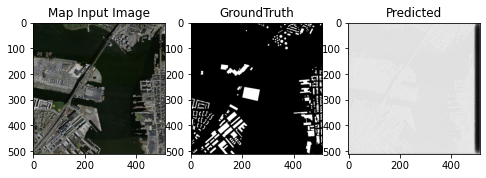

Displayinng results at: 1
Epoch 2/10
141/141 [==============================] - 549s 4s/step - loss: 0.0313 - accuracy: 0.8560 - jaccard_coef: 0.1021 - jaccard_coef_int: 0.0520 - val_loss: 0.0844 - val_accuracy: 0.7547 - val_jaccard_coef: 0.1545 - val_jaccard_coef_int: 0.2326


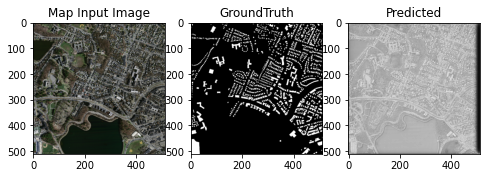

Displayinng results at: 2
Epoch 3/10
141/141 [==============================] - 536s 4s/step - loss: 0.0310 - accuracy: 0.8535 - jaccard_coef: 0.1136 - jaccard_coef_int: 0.0866 - val_loss: 0.1041 - val_accuracy: 0.6091 - val_jaccard_coef: 0.1650 - val_jaccard_coef_int: 0.2708


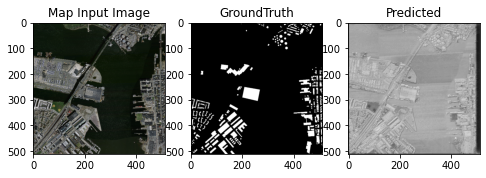

Displayinng results at: 3
Epoch 4/10
141/141 [==============================] - 528s 4s/step - loss: 0.0315 - accuracy: 0.8441 - jaccard_coef: 0.1311 - jaccard_coef_int: 0.1152 - val_loss: 0.0620 - val_accuracy: 0.8125 - val_jaccard_coef: 0.1640 - val_jaccard_coef_int: 0.2950


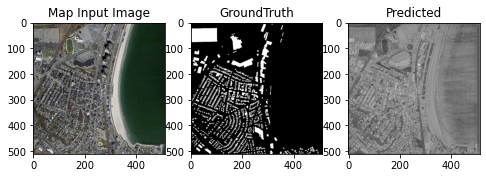

Displayinng results at: 4
Epoch 5/10
141/141 [==============================] - 540s 4s/step - loss: 0.0294 - accuracy: 0.8526 - jaccard_coef: 0.1241 - jaccard_coef_int: 0.1081 - val_loss: 0.0702 - val_accuracy: 0.7887 - val_jaccard_coef: 0.1696 - val_jaccard_coef_int: 0.3293


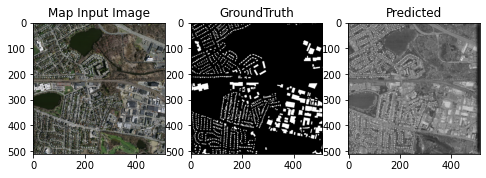

Displayinng results at: 5
Epoch 6/10
141/141 [==============================] - 528s 4s/step - loss: 0.0288 - accuracy: 0.8580 - jaccard_coef: 0.1231 - jaccard_coef_int: 0.1172 - val_loss: 0.0399 - val_accuracy: 0.8206 - val_jaccard_coef: 0.1724 - val_jaccard_coef_int: 0.2500


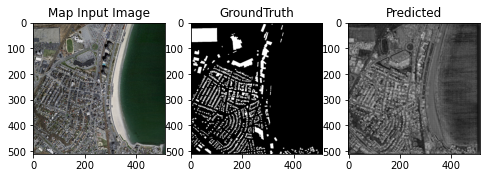

Displayinng results at: 6
Epoch 7/10
141/141 [==============================] - 521s 4s/step - loss: 0.0274 - accuracy: 0.8652 - jaccard_coef: 0.1245 - jaccard_coef_int: 0.1366 - val_loss: 0.0370 - val_accuracy: 0.7960 - val_jaccard_coef: 0.1583 - val_jaccard_coef_int: 0.0644


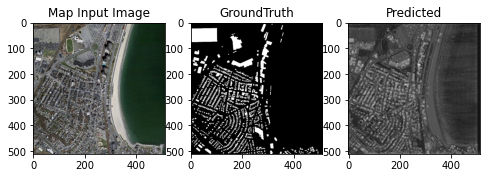

Displayinng results at: 7
Epoch 8/10
141/141 [==============================] - 523s 4s/step - loss: 0.0272 - accuracy: 0.8657 - jaccard_coef: 0.1264 - jaccard_coef_int: 0.1396 - val_loss: 0.0417 - val_accuracy: 0.8169 - val_jaccard_coef: 0.1672 - val_jaccard_coef_int: 0.2219


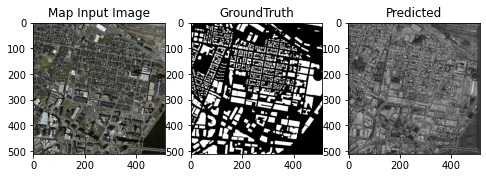

Displayinng results at: 8
Epoch 9/10
141/141 [==============================] - 520s 4s/step - loss: 0.0275 - accuracy: 0.8631 - jaccard_coef: 0.1281 - jaccard_coef_int: 0.1418 - val_loss: 0.0445 - val_accuracy: 0.8130 - val_jaccard_coef: 0.1627 - val_jaccard_coef_int: 0.2022


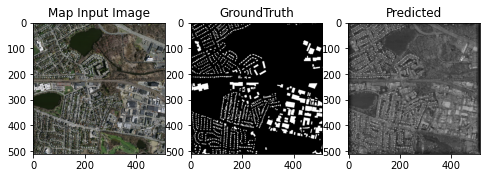

Displayinng results at: 9
Epoch 10/10
141/141 [==============================] - 549s 4s/step - loss: 0.0303 - accuracy: 0.8493 - jaccard_coef: 0.1359 - jaccard_coef_int: 0.1444 - val_loss: 0.0367 - val_accuracy: 0.8136 - val_jaccard_coef: 0.1703 - val_jaccard_coef_int: 0.1928


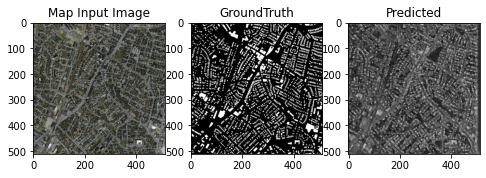

Displayinng results at: 10


In [15]:
EPOCHS = 5
BATCH_SIZE = 8
# fit the model
history = renet_unet.fit(train_generator,epochs=EPOCHS,batch_size=8,verbose = 1,validation_data = test_generator,callbacks= callbacks)

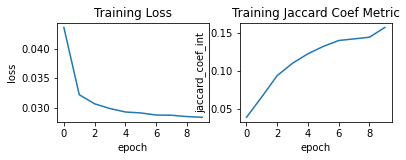

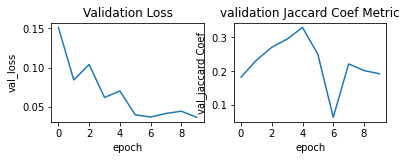

In [16]:
plt.subplot(2,2,1)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.subplot(2,2,2)
plt.plot(history.history["jaccard_coef_int"])
plt.title("Training Jaccard Coef Metric")
plt.ylabel("jaccard_coef_int")
plt.xlabel("epoch")
plt.show()

plt.subplot(2,2,3)
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")

plt.subplot(2,2,4)
plt.plot(history.history["val_jaccard_coef_int"])
plt.title("validation Jaccard Coef Metric")
plt.ylabel("val_jaccard Coef")
plt.xlabel("epoch")
plt.show()

## Residual UNET

In [18]:
from tensorflow import keras
# source https://github.com/nikhilroxtomar/Deep-Residual-Unet
def bn_act(x, act=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c

def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input((512, 512, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model


In [30]:
smooth = 1.
# define Metrics
metrics=['accuracy',jaccard_coef,jaccard_coef_int]
# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model Compile 
res_unet = ResUNet()
res_unet.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=metrics)

In [31]:
# define Display Call abck
PATIENCE = 5
class Display_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % PATIENCE == 0:
            input_img, mask_img = get_sample_image()
            predicted_img = self.model.predict(np.expand_dims(input_img, axis=0))
            predicted_img = np.reshape(predicted_img, (predicted_img.shape[1], predicted_img.shape[2], 1))
            display_predictions(predicted_img, mask_img, input_img)
            final_image = cv2.hconcat([mask_img,cv2.resize(mask_img,(predicted_img.shape[0],predicted_img.shape[1]))])
            # save the logs images on Neptune
            #run['predictions/{}'.format(epoch+1)].upload(File.as_image(final_image))
            print("Displayinng results at: {}".format(epoch + 1))

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(monitor='val_jaccard_coef_int',patience=10, verbose=1, mode='max')
# Define Callbacks
callbacks = [early_stopping,Display_callback()]


In [ ]:

trainable_count = [tf.keras.backend.count_params(p) for p in res_unet.trainable_weights]
non_trainable_count = [tf.keras.backend.count_params(p) for p in res_unet.non_trainable_weights]

print("Total trainable params :",np.sum(trainable_count))
print("Non trainable Weights :",np.sum(non_trainable_count))

Epoch 1/50
141/141 [==============================] - 458s 3s/step - loss: 0.2086 - accuracy: 0.8922 - jaccard_coef: 0.3228 - jaccard_coef_int: 0.4469 - val_loss: 0.3318 - val_accuracy: 0.8408 - val_jaccard_coef: 0.3173 - val_jaccard_coef_int: 0.3708
Epoch 2/50
141/141 [==============================] - 465s 3s/step - loss: 0.2050 - accuracy: 0.8933 - jaccard_coef: 0.3292 - jaccard_coef_int: 0.4581 - val_loss: 0.2580 - val_accuracy: 0.8609 - val_jaccard_coef: 0.3817 - val_jaccard_coef_int: 0.4731
Epoch 3/50
141/141 [==============================] - 539s 4s/step - loss: 0.2066 - accuracy: 0.8930 - jaccard_coef: 0.3267 - jaccard_coef_int: 0.4613 - val_loss: 0.2560 - val_accuracy: 0.8628 - val_jaccard_coef: 0.3827 - val_jaccard_coef_int: 0.4914
Epoch 4/50
141/141 [==============================] - 547s 4s/step - loss: 0.2065 - accuracy: 0.8928 - jaccard_coef: 0.3260 - jaccard_coef_int: 0.4543 - val_loss: 0.2653 - val_accuracy: 0.8566 - val_jaccard_coef: 0.3623 - val_jaccard_coef_int: 0.4

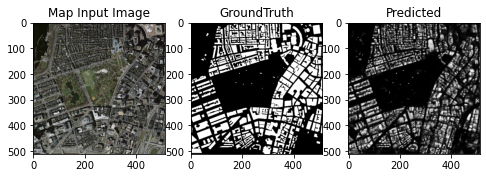

Displayinng results at: 5
Epoch 6/50
141/141 [==============================] - 491s 3s/step - loss: 0.1988 - accuracy: 0.8959 - jaccard_coef: 0.3362 - jaccard_coef_int: 0.4725 - val_loss: 0.2871 - val_accuracy: 0.8532 - val_jaccard_coef: 0.3712 - val_jaccard_coef_int: 0.4399
Epoch 7/50
141/141 [==============================] - 439s 3s/step - loss: 0.2005 - accuracy: 0.8950 - jaccard_coef: 0.3390 - jaccard_coef_int: 0.4695 - val_loss: 0.2522 - val_accuracy: 0.8651 - val_jaccard_coef: 0.3857 - val_jaccard_coef_int: 0.5017
Epoch 8/50
141/141 [==============================] - 468s 3s/step - loss: 0.1992 - accuracy: 0.8958 - jaccard_coef: 0.3391 - jaccard_coef_int: 0.4728 - val_loss: 0.2613 - val_accuracy: 0.8594 - val_jaccard_coef: 0.3691 - val_jaccard_coef_int: 0.4687
Epoch 9/50
141/141 [==============================] - 452s 3s/step - loss: 0.1944 - accuracy: 0.8977 - jaccard_coef: 0.3495 - jaccard_coef_int: 0.4769 - val_loss: 0.2672 - val_accuracy: 0.8608 - val_jaccard_coef: 0.3754 -

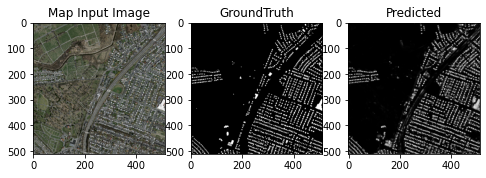

Displayinng results at: 10
Epoch 11/50
141/141 [==============================] - 489s 3s/step - loss: 0.1987 - accuracy: 0.8962 - jaccard_coef: 0.3453 - jaccard_coef_int: 0.4706 - val_loss: 0.2459 - val_accuracy: 0.8690 - val_jaccard_coef: 0.4141 - val_jaccard_coef_int: 0.5112
Epoch 12/50
141/141 [==============================] - 480s 3s/step - loss: 0.1928 - accuracy: 0.8979 - jaccard_coef: 0.3506 - jaccard_coef_int: 0.4845 - val_loss: 0.2518 - val_accuracy: 0.8643 - val_jaccard_coef: 0.3914 - val_jaccard_coef_int: 0.4868
Epoch 13/50
141/141 [==============================] - 481s 3s/step - loss: 0.1908 - accuracy: 0.8990 - jaccard_coef: 0.3557 - jaccard_coef_int: 0.4874 - val_loss: 0.2573 - val_accuracy: 0.8632 - val_jaccard_coef: 0.3976 - val_jaccard_coef_int: 0.4920
Epoch 14/50
141/141 [==============================] - 499s 4s/step - loss: 0.1912 - accuracy: 0.8989 - jaccard_coef: 0.3548 - jaccard_coef_int: 0.4924 - val_loss: 0.2349 - val_accuracy: 0.8712 - val_jaccard_coef: 0.4

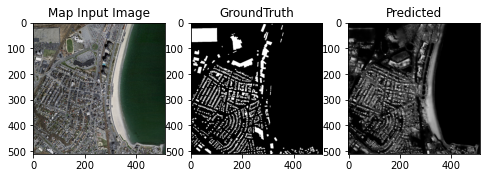

Displayinng results at: 15
Epoch 16/50
141/141 [==============================] - 468s 3s/step - loss: 0.2008 - accuracy: 0.8954 - jaccard_coef: 0.3403 - jaccard_coef_int: 0.4691 - val_loss: 0.2584 - val_accuracy: 0.8611 - val_jaccard_coef: 0.3702 - val_jaccard_coef_int: 0.4702
Epoch 17/50
141/141 [==============================] - 483s 3s/step - loss: 0.1916 - accuracy: 0.8987 - jaccard_coef: 0.3560 - jaccard_coef_int: 0.4835 - val_loss: 0.2961 - val_accuracy: 0.8576 - val_jaccard_coef: 0.3833 - val_jaccard_coef_int: 0.4567
Epoch 18/50
141/141 [==============================] - 496s 4s/step - loss: 0.1893 - accuracy: 0.8999 - jaccard_coef: 0.3586 - jaccard_coef_int: 0.4947 - val_loss: 0.2581 - val_accuracy: 0.8636 - val_jaccard_coef: 0.4027 - val_jaccard_coef_int: 0.4898
Epoch 19/50
141/141 [==============================] - 494s 3s/step - loss: 0.1926 - accuracy: 0.8984 - jaccard_coef: 0.3521 - jaccard_coef_int: 0.4838 - val_loss: 0.2784 - val_accuracy: 0.8574 - val_jaccard_coef: 0.3

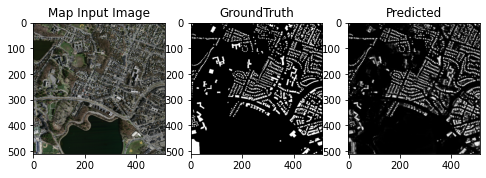

Displayinng results at: 20
Epoch 21/50
141/141 [==============================] - 506s 4s/step - loss: 0.1880 - accuracy: 0.9001 - jaccard_coef: 0.3627 - jaccard_coef_int: 0.4965 - val_loss: 0.2461 - val_accuracy: 0.8693 - val_jaccard_coef: 0.4210 - val_jaccard_coef_int: 0.5141
Epoch 22/50
141/141 [==============================] - 527s 4s/step - loss: 0.1864 - accuracy: 0.9010 - jaccard_coef: 0.3668 - jaccard_coef_int: 0.5027 - val_loss: 0.2448 - val_accuracy: 0.8692 - val_jaccard_coef: 0.4194 - val_jaccard_coef_int: 0.5195
Epoch 23/50
141/141 [==============================] - 491s 3s/step - loss: 0.1974 - accuracy: 0.8968 - jaccard_coef: 0.3461 - jaccard_coef_int: 0.4789 - val_loss: 0.2539 - val_accuracy: 0.8644 - val_jaccard_coef: 0.3922 - val_jaccard_coef_int: 0.4908
Epoch 24/50
141/141 [==============================] - 510s 4s/step - loss: 0.1890 - accuracy: 0.8999 - jaccard_coef: 0.3616 - jaccard_coef_int: 0.4954 - val_loss: 0.2505 - val_accuracy: 0.8704 - val_jaccard_coef: 0.4

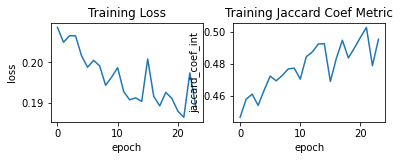

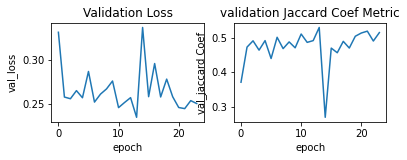

In [55]:
EPOCHS = 10
BATCH_SIZE = 8
# fit the model
history = res_unet.fit(train_generator,epochs=EPOCHS,batch_size=8,verbose = 1,validation_data = test_generator,callbacks= callbacks)

plt.subplot(2,2,1)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.subplot(2,2,2)
plt.plot(history.history["jaccard_coef_int"])
plt.title("Training Jaccard Coef Metric")
plt.ylabel("jaccard_coef_int")
plt.xlabel("epoch")
plt.show()

plt.subplot(2,2,3)
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")

plt.subplot(2,2,4)
plt.plot(history.history["val_jaccard_coef_int"])
plt.title("validation Jaccard Coef Metric")
plt.ylabel("val_jaccard Coef")
plt.xlabel("epoch")
plt.show()

In [28]:
def get_countours(mask_image):
    #get countours
    edged = cv2.Canny(mask_image, 0.5, 1)
    # Finding Contours
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

def draw_countours(input_image,mask_image):
    output_image = input_image.copy()
    contours = get_countours(mask_image=mask_image)
    for contour in contours:
            cv2.drawContours(output_image, contour, -1, (0, 255, 0), 3)
    return output_image

def process_image(input_image,img_shape=(512,512)):
    target_image = cv2.resize(input_image,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA)
    target_image = cv2.cvtColor(target_image,cv2.COLOR_BGR2RGB)
    target_image = target_image.astype(np.float32)
    return target_image/255.0


def test_segmentation_mask(image_list,model,n_to_show=10,IMG_SHAPE=(512,512)):
    random_images = np.random.choice(image_list,n_to_show) 
    figure = plt.figure(figsize=(75,45))

    for i,test_image_path in enumerate(random_images):
        input_image = cv2.imread(test_image_path)
        mask_img = cv2.imread(test_image_path.replace('test','test_labels'))
        
        target_img = process_image(input_image=input_image,img_shape=(IMG_SHAPE[0],IMG_SHAPE[1]))
        
        mask_img = cv2.cvtColor(mask_img,cv2.COLOR_BGR2RGB)
        # mask_img = cv2.resize(mask_img,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA)
        ground_truth = draw_countours(input_image=input_image,mask_image=mask_img)
        
        predicted_mask = np.squeeze(model.predict(np.expand_dims(target_img, axis=0)),axis=0) # normalize image before sending for prediction (512,512,1)
        predicted_mask = cv2.cvtColor(decode_segmentation_masks(predicted_mask,n_classes=2),cv2.COLOR_GRAY2BGR)
        predicted_mask = cv2.resize(predicted_mask,(input_image.shape[0],input_image.shape[1]))

        model_prediction = draw_countours(input_image=input_image,mask_image=predicted_mask)

        # gt_overlay = cv2.addWeighted(input_image,0.35,mask_img,0.65,1)
        # predicted_overlay = cv2.addWeighted(input_image, 0.35, predicted_mask, 0.65, 0)
        
        final_img = cv2.hconcat([ground_truth,model_prediction])

        sub = figure.add_subplot(n_to_show,2,i+1)
        sub.set_title("MOdel visualization(Ground truth/Predicted Mask)")
        sub.axis='off'
        sub.imshow(final_img)

# test_segmentation_mask(test_images,res_unet,n_to_show=1)

## Using Microsoft Efficient U7 model as UNET 

In [14]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss


BACKBONE = 'efficientnetb7'
preprocess_input = get_preprocessing(BACKBONE)
eff_b7 = Unet(BACKBONE, encoder_weights='imagenet', classes=1)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
258449408/258434480 [==============================] - 32s 0us/step


In [18]:
print("Input Shape of Model :",eff_b7.input_shape)
print("Output shape of Model:",eff_b7.output_shape)

Input Shape of Model : (None, None, None, 3)
Output shape of Model: (None, None, None, 1)


In [15]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
    
def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [19]:
# define Metrics
metrics=['accuracy',jaccard_coef,jaccard_coef_int]
# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model Compile
eff_b7.compile(
    optimizer=optimizer,
    loss=bce_logdice_loss,
    metrics=metrics
)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# define Display Call abck
PATIENCE = 10
class Display_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % PATIENCE == 0:
            input_img, mask_img = get_sample_image()
            predicted_img = self.model.predict(np.expand_dims(input_img, axis=0))
            predicted_img = np.reshape(predicted_img, (predicted_img.shape[1], predicted_img.shape[2], 1))
            display_predictions(predicted_img, mask_img, input_img)
            # save the logs images on Neptune
            #run['predictions/{}'.format(epoch+1)].upload(File.as_image(final_image))
            print("Displayinng results at: {}".format(epoch + 1))

reduce_lr = ReduceLROnPlateau(monitor='val_jaccard_coef_int', factor=0.5, mode='max',patience=20, min_lr=0.0001)
# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(monitor='val_jaccard_coef_int',patience=10, verbose=1, mode='max')
# Define Callbacks
callbacks = [early_stopping,Display_callback(),reduce_lr]


In [22]:
trainable_count = [tf.keras.backend.count_params(p) for p in eff_b7.trainable_weights]
non_trainable_count = [tf.keras.backend.count_params(p) for p in eff_b7.non_trainable_weights]

print("Total trainable params :",np.sum(trainable_count))
print("Non trainable Weights :",np.sum(non_trainable_count))

Total trainable params : 74735393
Non trainable Weights : 312704


141/141 [==============================] - 143s 1s/step - loss: 0.5958 - accuracy: 0.9082 - jaccard_coef: 0.4870 - jaccard_coef_int: 0.5608 - val_loss: 0.6682 - val_accuracy: 0.8764 - val_jaccard_coef: 0.5144 - val_jaccard_coef_int: 0.5628 - lr: 1.0000e-04
Epoch 48/50
141/141 [==============================] - 144s 1s/step - loss: 0.5925 - accuracy: 0.9087 - jaccard_coef: 0.4916 - jaccard_coef_int: 0.5646 - val_loss: 0.6537 - val_accuracy: 0.8784 - val_jaccard_coef: 0.5192 - val_jaccard_coef_int: 0.5684 - lr: 1.0000e-04
Epoch 49/50
141/141 [==============================] - 144s 1s/step - loss: 0.5980 - accuracy: 0.9080 - jaccard_coef: 0.4920 - jaccard_coef_int: 0.5620 - val_loss: 0.6306 - val_accuracy: 0.8793 - val_jaccard_coef: 0.5246 - val_jaccard_coef_int: 0.5761 - lr: 1.0000e-04
Epoch 50/50
141/141 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.9087 - jaccard_coef: 0.4916 - jaccard_coef_int: 0.5657

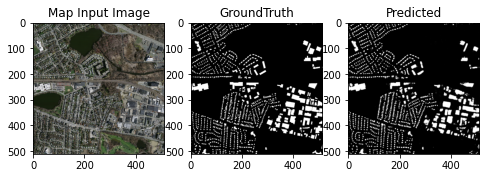

Displayinng results at: 50
141/141 [==============================] - 145s 1s/step - loss: 0.5900 - accuracy: 0.9087 - jaccard_coef: 0.4916 - jaccard_coef_int: 0.5657 - val_loss: 0.6559 - val_accuracy: 0.8789 - val_jaccard_coef: 0.5213 - val_jaccard_coef_int: 0.5687 - lr: 1.0000e-04


In [23]:
EPOCHS = 50 
BATCH_SIZE = 8
# fit the model
history = eff_b7.fit(train_generator,epochs=EPOCHS,batch_size=1,verbose = 1,validation_data = test_generator,callbacks= callbacks)

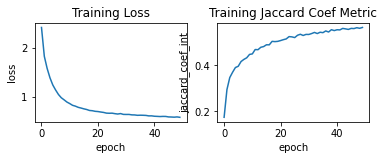

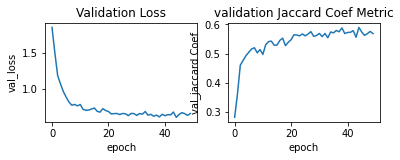

In [24]:
plt.subplot(2,2,1)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.subplot(2,2,2)
plt.plot(history.history["jaccard_coef_int"])
plt.title("Training Jaccard Coef Metric")
plt.ylabel("jaccard_coef_int")
plt.xlabel("epoch")
plt.show()

plt.subplot(2,2,3)
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")

plt.subplot(2,2,4)
plt.plot(history.history["val_jaccard_coef_int"])
plt.title("validation Jaccard Coef Metric")
plt.ylabel("val_jaccard Coef")
plt.xlabel("epoch")
plt.show()

## Run Inference on Test Images with Mapping Contours

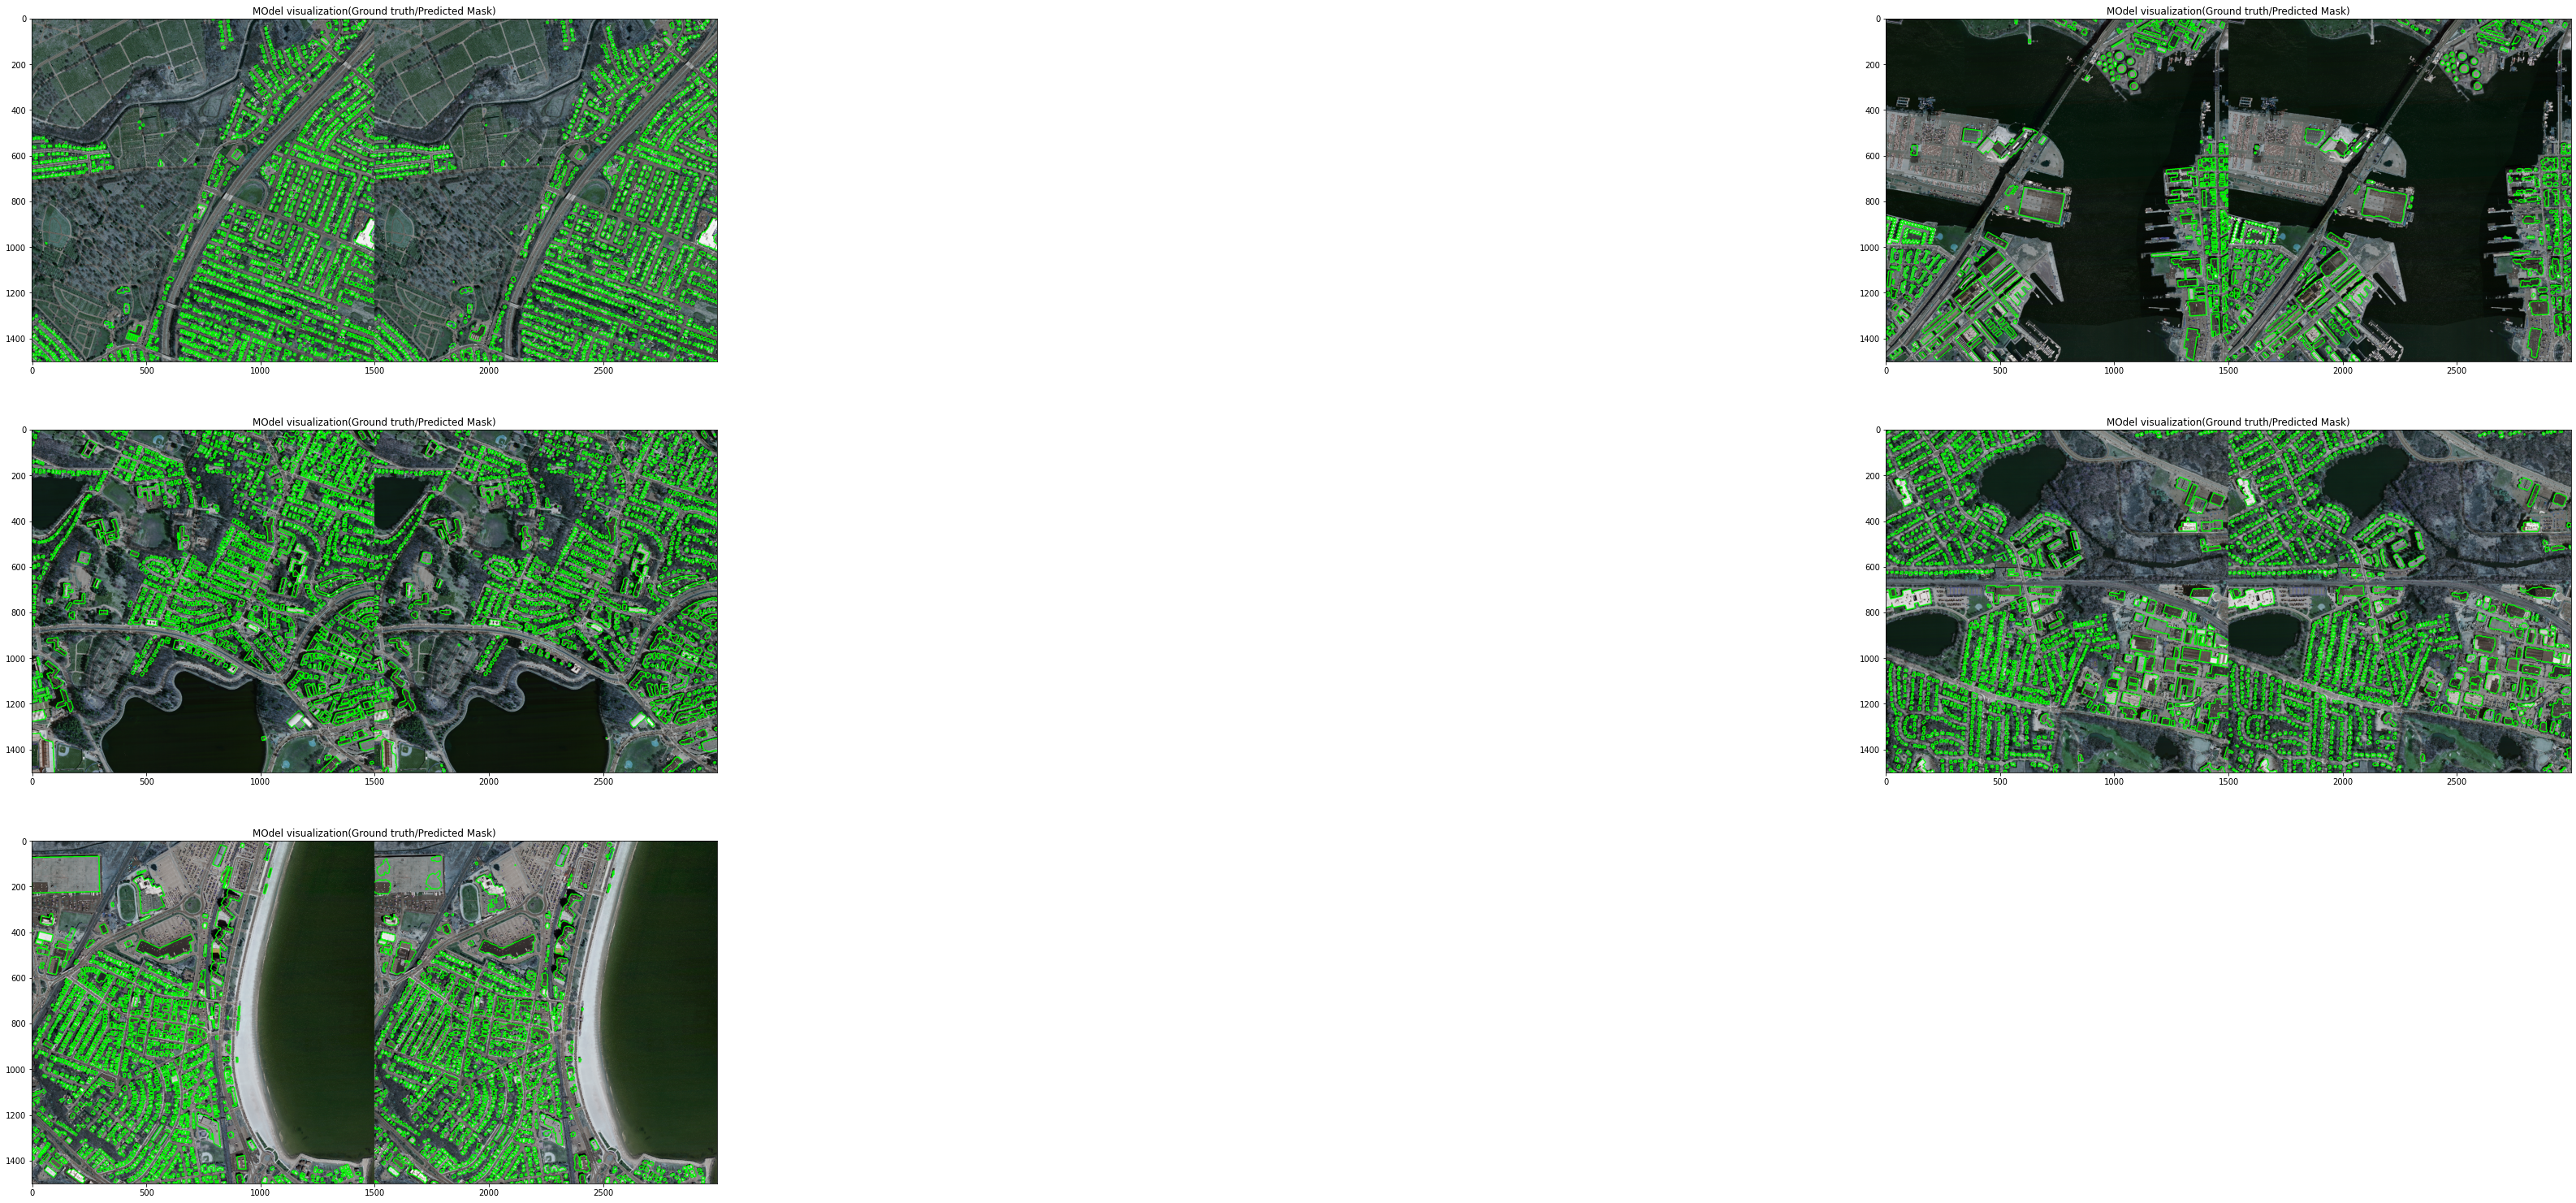

In [30]:
test_segmentation_mask(test_images,eff_b7,n_to_show=5)